<a href="https://colab.research.google.com/github/pavitraa0625/ML-LAB/blob/main/LAB_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -----------------------------
# Lab08 helper functions (ALL functions in one cell)
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import pinv
import math

# 1) Summation unit
def summation_unit(x, w):
    """
    x : 1-D array of inputs (length n)
    w : weights array of length n+1 where w[0] is bias weight
    returns net input (scalar)
    """
    # bias input is 1
    return w[0] + np.dot(w[1:], x)

# 2) Activation functions and their derivatives (derivative wrt net input)
def act_step(net):
    return 1.0 if net >= 0.0 else 0.0

def act_bipolar_step(net):
    return 1.0 if net >= 0.0 else -1.0

def act_sigmoid(net):
    # numerically stable sigmoid
    return 1.0 / (1.0 + np.exp(-net))

def d_sigmoid_from_output(out):
    return out * (1.0 - out)

def act_tanh(net):
    return np.tanh(net)

def d_tanh_from_output(out):
    return 1.0 - out**2

def act_relu(net):
    return net if net > 0 else 0.0

def d_relu_from_net(net):
    return 1.0 if net > 0 else 0.0

def act_leaky_relu(net, alpha=0.01):
    return net if net > 0 else alpha * net

def d_leaky_relu_from_net(net, alpha=0.01):
    return 1.0 if net > 0 else alpha

# 3) Comparator / error calculation (SSE)
def sum_square_error(targets, outputs):
    # returns sum of squared errors
    arr = np.array(targets) - np.array(outputs)
    return float(np.sum(arr * arr))

# 4) Perceptron training (supports step-perceptron update and continuous activations via delta rule)
def perceptron_train(X, y, w_init, alpha=0.05, activation='step', max_epochs=1000, tol=0.002, bipolar=False):
    """
    X : shape (N, d) numpy array
    y : shape (N,) target values (0/1 for step). If bipolar=True, y should be 0/1 and will be mapped to -1/1
    w_init : numpy array length d+1 (bias + d weights)
    activation : 'step', 'bipolar_step', 'sigmoid', 'tanh', 'relu', 'leaky_relu'
    Returns: w, error_history(list SSE per epoch), epochs_run
    Note: no prints inside this function (lab guideline)
    """
    N, d = X.shape
    w = w_init.astype(float).copy()
    error_history = []
    # transform targets for bipolar if required
    if bipolar:
        y_train = np.where(np.array(y) == 0, -1.0, 1.0)
    else:
        y_train = np.array(y, dtype=float)

    for epoch in range(1, max_epochs + 1):
        outputs = []
        # online learning (sample-wise update)
        for i in range(N):
            xi = X[i]
            net = summation_unit(xi, w)
            # choose activation
            if activation == 'step':
                out = act_step(net)
                # perceptron learning rule (for step)
                error = y_train[i] - out
                # update all weights (including bias)
                w[0] += alpha * error * 1.0
                w[1:] += alpha * error * xi
            elif activation == 'bipolar_step':
                out = act_bipolar_step(net)
                error = y_train[i] - out
                # perceptron-like update with bipolar targets
                w[0] += alpha * error * 1.0
                w[1:] += alpha * error * xi
            else:
                # continuous activation: use delta rule (gradient descent)
                if activation == 'sigmoid':
                    out = act_sigmoid(net)
                    deriv = d_sigmoid_from_output(out)
                elif activation == 'tanh':
                    out = act_tanh(net)
                    deriv = d_tanh_from_output(out)
                elif activation == 'relu':
                    out = act_relu(net)
                    deriv = d_relu_from_net(net)
                elif activation == 'leaky_relu':
                    out = act_leaky_relu(net)
                    deriv = d_leaky_relu_from_net(net)
                else:
                    # default to sigmoid
                    out = act_sigmoid(net)
                    deriv = d_sigmoid_from_output(out)
                error = y_train[i] - out
                delta = alpha * error * deriv
                w[0] += delta * 1.0
                w[1:] += delta * xi
            outputs.append(out)
        sse = sum_square_error(y_train, outputs)
        error_history.append(sse)
        if sse <= tol:
            return w, error_history, epoch
    return w, error_history, max_epochs

# 5) Perceptron predict utility
def perceptron_predict(X, w, activation='step'):
    outs = []
    for i in range(X.shape[0]):
        net = summation_unit(X[i], w)
        if activation == 'step':
            outs.append(act_step(net))
        elif activation == 'bipolar_step':
            outs.append(act_bipolar_step(net))
        elif activation == 'sigmoid':
            outs.append(act_sigmoid(net))
        elif activation == 'tanh':
            outs.append(act_tanh(net))
        elif activation == 'relu':
            outs.append(act_relu(net))
        elif activation == 'leaky_relu':
            outs.append(act_leaky_relu(net))
        else:
            outs.append(act_step(net))
    return np.array(outs)

# 6) Pseudo-inverse linear solution (for comparison)
def pseudo_inverse_solution(X, y):
    """
    Computes weights using Moore-Penrose pseudo-inverse for linear model y = W0 + W1*x1 + ...
    X shape (N, d)
    y shape (N,)
    returns w vector length d+1
    """
    N, d = X.shape
    X_aug = np.concatenate([np.ones((N,1)), X], axis=1)
    w = pinv(X_aug).dot(np.array(y))
    return w

# 7) Simple feed-forward MLP (one hidden layer) trained with backprop (sigmoid activations)
def mlp_backprop_train(X, y, hidden_size=2, alpha=0.05, max_epochs=1000, tol=0.002, verbose=False):
    """
    X: shape (N, d)
    y: shape (N,) with targets 0/1
    simple architecture: input -> hidden (sigmoid) -> output (sigmoid)
    returns dict with weights: W1 (hidden_size x (d+1)), W2 ((1) x (hidden_size+1)), error_history
    """
    N, d = X.shape
    # initialize weights small random
    rng = np.random.RandomState(42)
    W1 = rng.normal(0, 0.5, size=(hidden_size, d + 1))  # including bias
    W2 = rng.normal(0, 0.5, size=(1, hidden_size + 1))  # output layer incl bias

    error_history = []
    for epoch in range(1, max_epochs + 1):
        epoch_errors = []
        for i in range(N):
            xi = X[i]
            target = y[i]
            # forward
            x_with_bias = np.concatenate([[1.0], xi])  # shape d+1
            net_h = W1.dot(x_with_bias)                # shape (hidden_size,)
            out_h = 1.0 / (1.0 + np.exp(-net_h))       # sigmoid hidden
            out_h_with_bias = np.concatenate([[1.0], out_h])  # hidden+ bias
            net_o = W2.dot(out_h_with_bias)            # shape (1,)
            out_o = 1.0 / (1.0 + np.exp(-net_o))[0]    # scalar

            # error
            err = target - out_o
            epoch_errors.append(err**2)

            # backprop
            d_o = out_o * (1.0 - out_o)               # derivative at output
            delta_o = err * d_o                       # scalar

            # gradient for W2
            grad_W2 = delta_o * out_h_with_bias       # shape hidden_size+1

            # backprop into hidden units
            # remove bias weight for backprop
            W2_no_bias = W2[:, 1:]                    # shape (1, hidden_size)
            delta_h = (W2_no_bias.T * delta_o).flatten() * (out_h * (1.0 - out_h))  # shape hidden_size

            # gradients for W1
            grad_W1 = np.outer(delta_h, x_with_bias)  # shape hidden_size x (d+1)

            # weight updates (gradient descent)
            W2 += alpha * grad_W2.reshape(W2.shape)
            W1 += alpha * grad_W1

        sse_epoch = np.sum(epoch_errors)
        error_history.append(sse_epoch)
        if sse_epoch <= tol:
            return {'W1': W1, 'W2': W2, 'error_history': error_history, 'epochs': epoch}
    return {'W1': W1, 'W2': W2, 'error_history': error_history, 'epochs': max_epochs}

def mlp_backprop_predict(X, model):
    W1 = model['W1']
    W2 = model['W2']
    outs = []
    for i in range(X.shape[0]):
        xi = X[i]
        x_with_bias = np.concatenate([[1.0], xi])
        net_h = W1.dot(x_with_bias)
        out_h = 1.0 / (1.0 + np.exp(-net_h))
        out_h_with_bias = np.concatenate([[1.0], out_h])
        net_o = W2.dot(out_h_with_bias)
        out_o = 1.0 / (1.0 + np.exp(-net_o))[0]
        outs.append(out_o)
    return np.array(outs)

# 8) Utility: plot error history
def plot_error_history(error_history, title="SSE vs Epochs"):
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(error_history)+1), error_history, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Sum-squared-error (SSE)")
    plt.title(title)
    plt.grid(True)
    plt.show()

# 9) PlantVillage loader helper using tensorflow_datasets OR from a local directory
def load_plant_village_tfds(classes_to_keep=None, img_size=(64,64), max_per_class=None):
    """
    Loads PlantVillage using tensorflow_datasets. Returns (X, y, label_names)
    X : ndarray shape (N, img_size[0]*img_size[1]*3)
    y : integer labels (0..)
    classes_to_keep : list of label names to keep (None => keep all)
    max_per_class : int or None (limit per class)
    Note: this function requires tensorflow and tensorflow_datasets installed.
    """
    import tensorflow as tf
    import tensorflow_datasets as tfds
    ds_all, info = tfds.load('plant_village', split='train', with_info=True, as_supervised=True)
    label_names = info.features['label'].names

    # prepare counters for max_per_class
    counters = {name:0 for name in label_names}
    X_list = []
    y_list = []
    # if classes_to_keep is given, restrict
    if classes_to_keep is None:
        classes_to_keep = label_names

    # iterate (note: converts to numpy)
    for img, lbl in tfds.as_numpy(ds_all):
        name = label_names[int(lbl)]
        if name not in classes_to_keep:
            continue
        if (max_per_class is not None) and (counters[name] >= max_per_class):
            continue
        # resize using tf
        img_resized = tf.image.resize(img, img_size).numpy().astype(np.float32) / 255.0
        X_list.append(img_resized.flatten())
        y_list.append(classes_to_keep.index(name))
        counters[name] += 1
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y, classes_to_keep

=== PART A: AND gate with perceptron (step activation) ===
Learned weights (AND - step): [-0.1   0.1   0.05]
Epochs run: 130


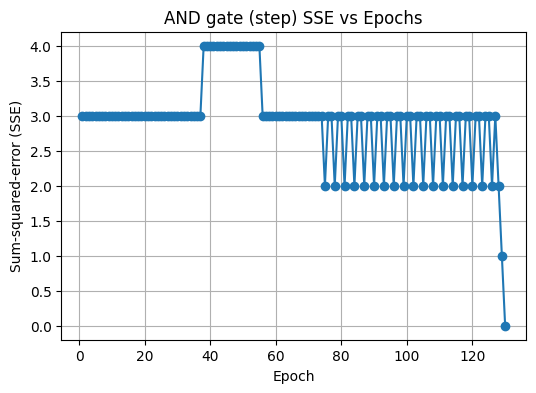


=== PART A3: Compare activations for AND (sigmoid, tanh, ReLU, bipolar) ===
Activation bipolar_step -> epochs: 68, final SSE: 0.000000


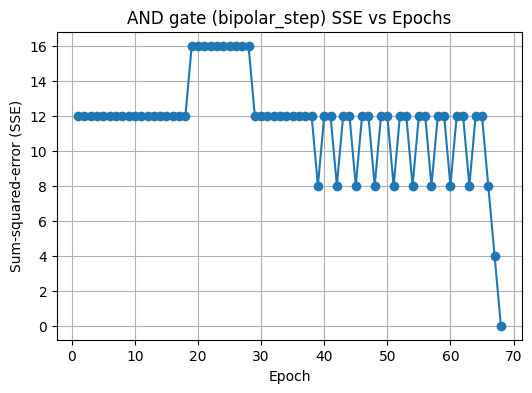

Activation sigmoid -> epochs: 1000, final SSE: 2.999638


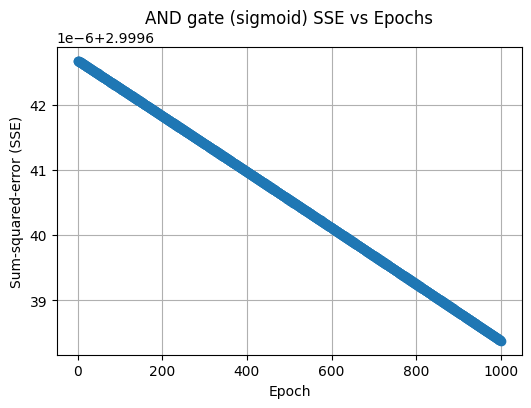

Activation tanh -> epochs: 1000, final SSE: 3.000000


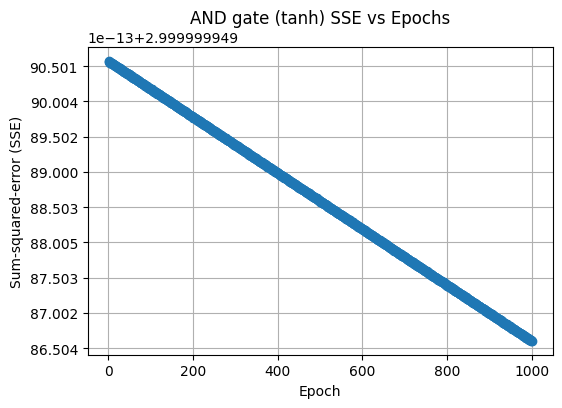

Activation relu -> epochs: 1000, final SSE: 1.000000


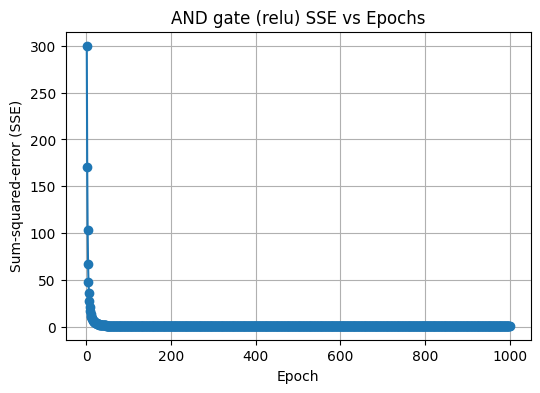


=== PART A4: Learning rate sweep for AND (step activation) ===
LR 0.10 -> epochs 68
LR 0.20 -> epochs 37
LR 0.30 -> epochs 23
LR 0.40 -> epochs 23
LR 0.50 -> epochs 19
LR 0.60 -> epochs 19
LR 0.70 -> epochs 15
LR 0.80 -> epochs 14
LR 0.90 -> epochs 13
LR 1.00 -> epochs 12


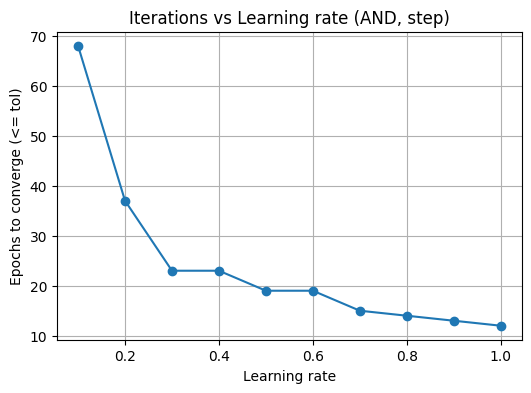


=== PART A5: Try XOR with perceptron (will not converge because XOR is not linearly separable) ===
XOR perceptron (step) final SSE: 1.0 epochs: 200


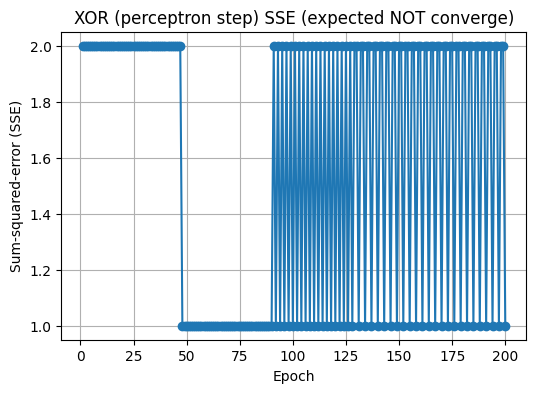


=== PART A6: Customer transaction example (sigmoid perceptron) ===
Customer sigmoid weights: [1.58042682 0.03080819 3.76881072 0.30441471 4.28584959]
Epochs run: 5000


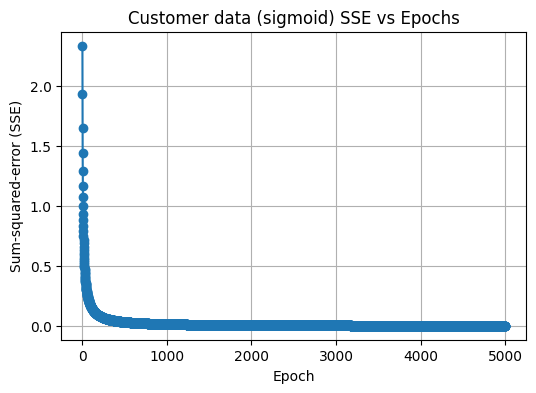


=== PART A7: Pseudo-inverse comparison (linear regression solve) ===
Pseudo-inverse weights (linear): [ 0.6        -0.09436819  0.21713405 -0.01342766  0.23416864]

=== PART A8: Small MLP (backprop) to learn AND ===
MLP (backprop) AND trained epochs: 10000


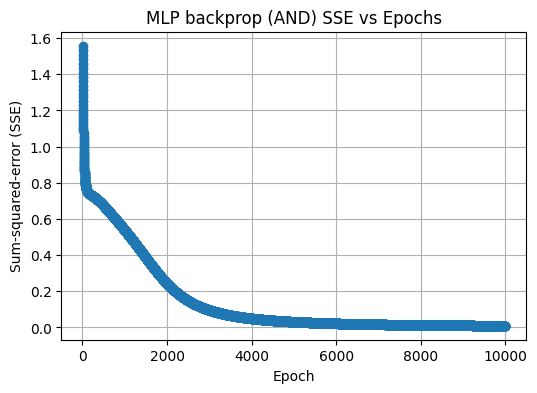


=== PART A9: MLP for XOR (should learn with hidden layer) ===
MLP (backprop) XOR trained epochs: 7366


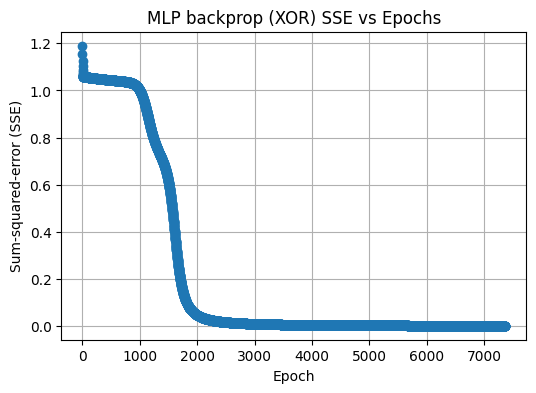

XOR predictions (MLP): [0 1 1 0] targets: [0 1 1 0]

=== PART A11/A12: Demo using scikit-learn MLPClassifier on PlantVillage (3 classes, 15,000 images) ===
Loading PlantVillage via tensorflow_datasets (may take a few minutes)...
Loaded 3860 images from classes: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold']
Class counts before capping: Counter({np.int64(1): 1908, np.int64(0): 1000, np.int64(2): 952})
Balanced subset selected: 3860 images (≈5000 per class)
Iteration 1, loss = 1.99343151
Iteration 2, loss = 0.74487117
Iteration 3, loss = 0.33577500
Iteration 4, loss = 0.15719895
Iteration 5, loss = 0.08566188
Iteration 6, loss = 0.03531109
Iteration 7, loss = 0.02328582
Iteration 8, loss = 0.02775883
Iteration 9, loss = 0.01403691
Iteration 10, loss = 0.00692855
Iteration 11, loss = 0.00466854
Iteration 12, loss = 0.00364240
Iteration 13, loss = 0.00304438
Iteration 14, loss = 0.00269107
Iteration 15, loss = 0.00242894
Iteration 16, loss = 0.00222756
Iteration 17

In [ ]:
# -----------------------------
# MAIN: run experiments (prints only here)
# -----------------------------
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Parameters (edit as needed)
alpha = 0.05
w_init = np.array([10.0, 0.2, -0.75])  # bias, w1, w2 (lab-specified initial weights)
max_epochs = 1000
tol = 0.002

print("=== PART A: AND gate with perceptron (step activation) ===")
# AND dataset
X_and = np.array([[0,0],[0,1],[1,0],[1,1]])
y_and = np.array([0,0,0,1])
# train
w_learned, err_hist, epochs = perceptron_train(X_and, y_and, w_init.copy(), alpha=alpha, activation='step', max_epochs=max_epochs, tol=tol)
print("Learned weights (AND - step):", w_learned)
print("Epochs run:", epochs)
plot_error_history(err_hist, title="AND gate (step) SSE vs Epochs")

print("\n=== PART A3: Compare activations for AND (sigmoid, tanh, ReLU, bipolar) ===")
activs = ['bipolar_step', 'sigmoid', 'tanh', 'relu']
results = {}
for act in activs:
    if act == 'bipolar_step':
        w_init2 = w_init.copy()
        w, hist, e = perceptron_train(X_and, y_and, w_init2, alpha=alpha, activation=act, max_epochs=max_epochs, tol=tol, bipolar=True)
    else:
        w, hist, e = perceptron_train(X_and, y_and, w_init.copy(), alpha=alpha, activation=act, max_epochs=max_epochs, tol=tol)
    results[act] = (w, hist, e)
    print(f"Activation {act} -> epochs: {e}, final SSE: {hist[-1]:.6f}")
    plot_error_history(hist, title=f"AND gate ({act}) SSE vs Epochs")

print("\n=== PART A4: Learning rate sweep for AND (step activation) ===")
lrs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
iters_for_lr = []
for lr in lrs:
    w, hist, e = perceptron_train(X_and, y_and, w_init.copy(), alpha=lr, activation='step', max_epochs=max_epochs, tol=tol)
    iters_for_lr.append(e)
    print(f"LR {lr:.2f} -> epochs {e}")
plt.figure(figsize=(6,4))
plt.plot(lrs, iters_for_lr, marker='o')
plt.xlabel("Learning rate")
plt.ylabel("Epochs to converge (<= tol)")
plt.title("Iterations vs Learning rate (AND, step)")
plt.grid(True)
plt.show()

print("\n=== PART A5: Try XOR with perceptron (will not converge because XOR is not linearly separable) ===")
X_xor = X_and.copy()
y_xor = np.array([0,1,1,0])
w_xor, hist_xor, e_xor = perceptron_train(X_xor, y_xor, w_init.copy(), alpha=alpha, activation='step', max_epochs=200)
print("XOR perceptron (step) final SSE:", hist_xor[-1], "epochs:", e_xor)
plot_error_history(hist_xor, title="XOR (perceptron step) SSE (expected NOT converge)")

print("\n=== PART A6: Customer transaction example (sigmoid perceptron) ===")
# Customer example from the lab (10 rows)
cust_X = np.array([
    [20,6,2,386],
    [16,3,6,289],
    [27,6,2,393],
    [19,1,2,110],
    [24,4,2,280],
    [22,1,5,167],
    [15,4,2,271],
    [18,4,2,274],
    [21,1,4,148],
    [16,2,4,198]
], dtype=float)
cust_y = np.array([1,1,1,0,1,0,1,1,0,0])  # 1 = High value, 0 = No

# normalize features
scaler = StandardScaler()
cust_Xs = scaler.fit_transform(cust_X)

# initialize weights (d+1)
w0 = np.zeros(cust_Xs.shape[1] + 1)
w_learned_cust, hist_cust, e_cust = perceptron_train(cust_Xs, cust_y, w0.copy(), alpha=0.1, activation='sigmoid', max_epochs=5000, tol=0.002)
print("Customer sigmoid weights:", w_learned_cust)
print("Epochs run:", e_cust)
plot_error_history(hist_cust, title="Customer data (sigmoid) SSE vs Epochs")

print("\n=== PART A7: Pseudo-inverse comparison (linear regression solve) ===")
w_pinv = pseudo_inverse_solution(cust_Xs, cust_y)
print("Pseudo-inverse weights (linear):", w_pinv)

print("\n=== PART A8: Small MLP (backprop) to learn AND ===")
mlp_model_and = mlp_backprop_train(X_and, y_and, hidden_size=2, alpha=0.05, max_epochs=10000, tol=0.002)
print("MLP (backprop) AND trained epochs:", mlp_model_and['epochs'])
plot_error_history(mlp_model_and['error_history'], title="MLP backprop (AND) SSE vs Epochs")

print("\n=== PART A9: MLP for XOR (should learn with hidden layer) ===")
mlp_model_xor = mlp_backprop_train(X_xor, y_xor, hidden_size=2, alpha=0.5, max_epochs=10000, tol=0.002)
print("MLP (backprop) XOR trained epochs:", mlp_model_xor['epochs'])
plot_error_history(mlp_model_xor['error_history'], title="MLP backprop (XOR) SSE vs Epochs")
# demonstrate predictions
preds_xor = (mlp_backprop_predict(X_xor, mlp_model_xor) >= 0.5).astype(int)
print("XOR predictions (MLP):", preds_xor, "targets:", y_xor)

# -------------------------
# PART A11/A12: Use sklearn MLPClassifier on PlantVillage (3 classes, 15,000 images)
# -------------------------
print("\n=== PART A11/A12: Demo using scikit-learn MLPClassifier on PlantVillage (3 classes, 15,000 images) ===")
use_tfds = True   # set False if you want to use a local path below
local_dataset_path = None  # e.g. "/content/drive/MyDrive/plant_village"

if use_tfds:
    try:
        print("Loading PlantVillage via tensorflow_datasets (may take a few minutes)...")
        # pick 3 classes explicitly (change these if you prefer other crops/diseases)
        demo_classes = [
            'Tomato___Early_blight',
            'Tomato___Late_blight',
            'Tomato___Leaf_Mold'
        ]
        Xpv, ypv, labels = load_plant_village_tfds(
            classes_to_keep=demo_classes,
            img_size=(64,64),
            max_per_class=6000  # keep up to 6000 per class, we’ll cap later
        )
        print("Loaded", Xpv.shape[0], "images from classes:", demo_classes)

        # cap total at 15000 (balanced across classes)
        from collections import Counter
        counts = Counter(ypv)
        print("Class counts before capping:", counts)

        Xpv_bal = []
        ypv_bal = []
        rng = np.random.default_rng(42)
        per_class_cap = 15000 // len(demo_classes)  # ~5000 each

        for cls in range(len(demo_classes)):
            idx_cls = np.where(ypv == cls)[0]
            if len(idx_cls) > per_class_cap:
                idx_cls = rng.choice(idx_cls, per_class_cap, replace=False)
            Xpv_bal.append(Xpv[idx_cls])
            ypv_bal.append(ypv[idx_cls])

        Xpv = np.vstack(Xpv_bal)
        ypv = np.concatenate(ypv_bal)
        print("Balanced subset selected:", Xpv.shape[0], "images (≈5000 per class)")
    except Exception as ex:
        print("Error loading tfds (maybe TF/TFDS not installed).", ex)
        Xpv = None
else:
    Xpv = None

if Xpv is not None and Xpv.size>0:
    # scale and train-test split
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.neural_network import MLPClassifier

    X_train, X_test, y_train, y_test = train_test_split(Xpv, ypv, test_size=0.2, random_state=42, stratify=ypv)
    scaler2 = StandardScaler()
    X_train_s = scaler2.fit_transform(X_train)
    X_test_s = scaler2.transform(X_test)

    # MLP training
    clf = MLPClassifier(hidden_layer_sizes=(128,), max_iter=50, verbose=True)
    clf.fit(X_train_s, y_train)
    score = clf.score(X_test_s, y_test)
    print("MLPClassifier demo accuracy (3 classes, 15k images):", score)
else:
    print("PlantVillage subset not loaded; set use_tfds=True or point to local dataset and rerun.")
